<b>Create a neural network from scratch for a multiclass classification task with the following architecture:<br><b>
Input layer: 4 neurons<br>
First hidden layer: 3 neurons<br>
Second hidden layer: 4 neurons<br>
Output layer: 3 neurons<br>
Generate a random dataset for a 3-class classification problem. Apply the designed neural network on generated dataset using the ReLU activation function in the hidden layers and the softmax activation function in the output
layer for multiclass classification. Use categorical cross-entropy as the loss function for training. Additionally, implement the Gradient Descent, Momentum based GD, NAG, AdaGrad, RMS prop, Adam optimizer as part of the training
process. Train the neural network using all optimizers and evaluate their performance on the dataset using performance metrics accuracy.

## Part 1: Dataset Generation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Generate dataset with 1000 records, 4 features, and 3 classes
X, y = make_classification(
    n_samples=1000, n_features=4, n_classes=3, n_informative=3, n_redundant=1, random_state=42
)

# Reshape labels for encoding
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output=False
y_encoded = encoder.fit_transform(y)

# Create a DataFrame for better readability
df = pd.DataFrame(X, columns=["Feature1", "Feature2", "Feature3", "Feature4"])
df['Class'] = encoder.inverse_transform(y_encoded)

# Display the first 5 records of the dataset
print(df.head())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"One-hot encoded labels:\n{y_encoded[:5]}")




   Feature1  Feature2  Feature3  Feature4  Class
0 -0.763577 -1.376368 -1.329212 -0.811226      2
1  0.798776  1.479103 -0.123530 -1.829664      1
2  0.251711 -1.183120  1.436410 -1.228790      0
3 -0.628048 -1.596094 -0.400482 -0.344888      2
4 -0.179159 -1.202407  0.872089  0.185406      0
Training data shape: (800, 4)
Testing data shape: (200, 4)
One-hot encoded labels:
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


## Part 2: Neural Network Initialization

In [ ]:
def initialize_parameters():
    np.random.seed(42)  # For reproducibility
    parameters = {
        "W1": np.random.randn(4, 3) * 0.01,  # Weights for input -> first hidden layer
        "b1": np.zeros((1, 3)),             # Bias for first hidden layer
        "W2": np.random.randn(3, 4) * 0.01, # Weights for first -> second hidden layer
        "b2": np.zeros((1, 4)),             # Bias for second hidden layer
        "W3": np.random.randn(4, 3) * 0.01, # Weights for second hidden -> output layer
        "b3": np.zeros((1, 3))              # Bias for output layer
    }
    return parameters

# Initialize parameters
parameters = initialize_parameters()

# Display initialized parameters
for key, value in parameters.items():
    print(f"{key} shape: {value.shape}")



W1 shape: (4, 3)
b1 shape: (1, 3)
W2 shape: (3, 4)
b2 shape: (1, 4)
W3 shape: (4, 3)
b3 shape: (1, 3)


## Part 3: Activation Functions

In [ ]:
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    exp_values = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Numerical stability
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

def forward_propagation(X, parameters):
    # First hidden layer
    Z1 = np.dot(X, parameters["W1"]) + parameters["b1"]
    A1 = relu(Z1)

    # Second hidden layer
    Z2 = np.dot(A1, parameters["W2"]) + parameters["b2"]
    A2 = relu(Z2)

    # Output layer
    Z3 = np.dot(A2, parameters["W3"]) + parameters["b3"]
    A3 = softmax(Z3)

    # Store intermediate values for backpropagation
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, cache


In [ ]:
# Test forward propagation
A3, cache = forward_propagation(X_train, parameters)

# Display the shape of output predictions
print(f"Output predictions shape: {A3.shape}")

# Display first 5 predictions
print(f"First 5 predictions:\n{A3[:5]}")


Output predictions shape: (800, 3)
First 5 predictions:
[[0.33333341 0.33333327 0.33333332]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333336 0.33333331]
 [0.33333332 0.33333354 0.33333315]
 [0.33333333 0.33333333 0.33333333]]


## Part 4: Implement Loss calculation

In [ ]:
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]  # Number of samples
    loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m  # Add epsilon for numerical stability
    return loss

# Test loss calculation
loss = compute_loss(y_train, A3)

# Display the calculated loss
print(f"Initial loss: {loss}")


Initial loss: 1.09861221465594


## Step 5: Implement Backward Propagation

In [ ]:
def relu_derivative(Z):
    return Z > 0  # Gradient of ReLU: 1 for Z > 0, otherwise 0

def backward_propagation(X, Y, parameters, cache):
    m = X.shape[0]  # Number of samples

    # Gradients for the output layer
    dZ3 = cache["A3"] - Y
    dW3 = np.dot(cache["A2"].T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    # Gradients for the second hidden layer
    dZ2 = np.dot(dZ3, parameters["W3"].T) * relu_derivative(cache["Z2"])
    dW2 = np.dot(cache["A1"].T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Gradients for the first hidden layer
    dZ1 = np.dot(dZ2, parameters["W2"].T) * relu_derivative(cache["Z1"])
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Store gradients in a dictionary
    gradients = {
        "dW1": dW1, "db1": db1,
        "dW2": dW2, "db2": db2,
        "dW3": dW3, "db3": db3
    }
    return gradients



In [ ]:
# Test backward propagation
gradients = backward_propagation(X_train, y_train, parameters, cache)

# Display the shapes of gradients
for key, value in gradients.items():
    print(f"{key} shape: {value.shape}")


dW1 shape: (4, 3)
db1 shape: (1, 3)
dW2 shape: (3, 4)
db2 shape: (1, 4)
dW3 shape: (4, 3)
db3 shape: (1, 3)


## Step 6: Gradient Descent Optimization and Training

In [ ]:
# Define the optimizers
optimizers = {
    'SGD': lambda params, grads, lr: {
        key: params[key] - lr * grads['d' + key]
        for key in params
    },
    'Momentum': lambda params, grads, lr, state=None, beta1=0.9: (
        {
            key: params[key] - lr * (
                beta1 * state.get(key, 0) + (1 - beta1) * grads['d' + key]
            )
            for key in params
        },
        state if state else {key: 0 for key in params}
    ),
    'NAG': lambda params, grads, lr, state=None, beta1=0.9: (
        {
            key: params[key] - lr * (
                beta1 * state.get(key, 0) + (1 - beta1) * grads['d' + key]
            )
            for key in params
        },
        {
            key: beta1 * state.get(key, 0) + (1 - beta1) * grads['d' + key]
            for key in params
        }
    ),
    'AdaGrad': lambda params, grads, lr, state=None, epsilon=1e-8: (
        {
            key: params[key] - lr * grads['d' + key] / (
                (state.get(key, 0) + grads['d' + key] ** 2 + epsilon) ** 0.5
            )
            for key in params
        },
        state if state else {key: 0 for key in params}
    ),
    'RMSprop': lambda params, grads, lr, state=None, beta1=0.9, epsilon=1e-8: (
        {
            key: params[key] - lr * grads['d' + key] / (
                (beta1 * state.get(key, 0) + (1 - beta1) * grads['d' + key] ** 2 + epsilon) ** 0.5
            )
            for key in params
        },
        state if state else {key: 0 for key in params}
    ),
    'Adam': lambda params, grads, lr, state=None, beta1=0.9, beta2=0.999, epsilon=1e-8: (
        {
            key: params[key] - lr * (
                (m := beta1 * state[key]['m'] + (1 - beta1) * grads['d' + key]) / (1 - beta1)
            ) / (
                (v := beta2 * state[key]['v'] + (1 - beta2) * grads['d' + key] ** 2) / (1 - beta2) + epsilon
            ) ** 0.5
            for key in params
        },
        {key: {'m': m, 'v': v} for key in params} if state else {key: {'m': 0, 'v': 0} for key in params}
    )
}

In [ ]:

import numpy as np

def update_parameters(parameters, gradients, learning_rate=0.01, optimizer='SGD', state=None, beta1=0.9, beta2=0.999, epsilon=1e-8):
    if optimizer == 'SGD':  # Standard Gradient Descent
        for key in parameters:
            parameters[key] -= learning_rate * gradients['d' + key]

    elif optimizer == 'Momentum':  # Momentum-based Gradient Descent
        if state is None:
            state = {key: np.zeros_like(parameters[key]) for key in parameters}
        for key in parameters:
            state[key] = beta1 * state[key] + (1 - beta1) * gradients['d' + key]
            parameters[key] -= learning_rate * state[key]

    elif optimizer == 'NAG':  # Nesterov Accelerated Gradient
        if state is None:
            state = {key: np.zeros_like(parameters[key]) for key in parameters}
        temp_params = {key: parameters[key] - beta1 * state[key] for key in parameters}
        for key in parameters:
            state[key] = beta1 * state[key] + (1 - beta1) * gradients['d' + key]
            parameters[key] -= learning_rate * state[key]

    elif optimizer == 'Adagrad':  # Adagrad
        if state is None:
            state = {key: np.zeros_like(parameters[key]) for key in parameters}
        for key in parameters:
            state[key] += gradients['d' + key] ** 2
            parameters[key] -= learning_rate * gradients['d' + key] / (np.sqrt(state[key]) + epsilon)

    elif optimizer == 'RMSprop':  # RMSprop
        if state is None:
            state = {key: np.zeros_like(parameters[key]) for key in parameters}
        for key in parameters:
            state[key] = beta1 * state[key] + (1 - beta1) * (gradients['d' + key] ** 2)
            parameters[key] -= learning_rate * gradients['d' + key] / (np.sqrt(state[key]) + epsilon)

    elif optimizer == 'Adam':  # Adam Optimizer
        if state is None:
            state = {key: {'m': np.zeros_like(parameters[key]), 'v': np.zeros_like(parameters[key])} for key in parameters}
        for key in parameters:
            state[key]['m'] = beta1 * state[key]['m'] + (1 - beta1) * gradients['d' + key]
            state[key]['v'] = beta2 * state[key]['v'] + (1 - beta2) * (gradients['d' + key] ** 2)
            m_corrected = state[key]['m'] / (1 - beta1)  # Bias correction for momentum
            v_corrected = state[key]['v'] / (1 - beta2)  # Bias correction for RMSprop
            parameters[key] -= learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)

    return parameters, state  # Return updated parameters and state


## Step 7: Evaluating the Model's Performance

In [ ]:
def predict(X, parameters):
    # Perform forward propagation to get predictions
    A3, _ = forward_propagation(X, parameters)

    # Get the predicted class by choosing the class with the highest probability
    predictions = np.argmax(A3, axis=1)
    return predictions

def compute_accuracy(y_true, y_pred):
    # Calculate accuracy by comparing predicted and true labels
    correct_predictions = np.sum(np.argmax(y_true, axis=1) == y_pred)
    accuracy = correct_predictions / y_true.shape[0] * 100
    return accuracy

# Test the model on the test set
num_epochs = 1000  # Number of training iterations
learning_rate = 0.01
optimizer = 'Adam'  # Choose your desired optimizer
state = None  # Initialize state for optimizers with state
parameters_trained = parameters.copy()  # Initialize trained parameters
for epoch in range(num_epochs):
  # Forward propagation
  A3, cache = forward_propagation(X_train, parameters_trained)

  # Compute loss
  loss = compute_loss(y_train, A3)

  # Backward propagation
  gradients = backward_propagation(X_train, y_train, parameters_trained, cache)

  # Update parameters
  parameters_trained, state = update_parameters(parameters_trained, gradients, learning_rate, optimizer, state)

  # Print loss every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.4f}")

  # Test the model on the test set (Now using trained parameters)
  y_pred = predict(X_test, parameters_trained)

# Calculate the accuracy
accuracy = compute_accuracy(y_test, y_pred)

# Display the accuracy
print(f"Test accuracy: {accuracy:.2f}%")


Epoch: 0, Loss: 1.0986
Epoch: 100, Loss: 1.0986
Epoch: 200, Loss: 1.0986
Epoch: 300, Loss: 1.0986
Epoch: 400, Loss: 1.0986
Epoch: 500, Loss: 1.0986
Epoch: 600, Loss: 1.0986
Epoch: 700, Loss: 1.0986
Epoch: 800, Loss: 1.0986
Epoch: 900, Loss: 1.0986
Test accuracy: 37.00%


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


## 8. Model Tuning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Assuming your dataset is loaded into a pandas DataFrame 'df'
# Example: df = pd.read_csv('your_data.csv')

# Print column names to verify the correct column name
print(df.columns)

# Replace 'target_column_name' with 'Class' as the actual target column
target_column_name = 'Class'

# Split the data into features and target
X = df.drop(target_column_name, axis=1)  # Features (drop target column)
y = df[target_column_name]  # Target column ('Class')

# Ensure y is a 1D array
y = y.values.flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV (for Logistic Regression)
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solvers to choose from
}

# Initialize GridSearchCV with Logistic Regression
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, n_jobs=-1)

# Fit the model with training data
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')



Index(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Class'], dtype='object')
Best Hyperparameters: {'C': 1, 'solver': 'liblinear'}
Accuracy: 64.00%


## Step 9: Evaluate the Model

In [ ]:
pip install matplotlib seaborn scikit-learn


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88        65
           1       0.81      0.92      0.86        62
           2       0.92      0.84      0.88        73

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200

ROC-AUC (Macro Average): 0.48


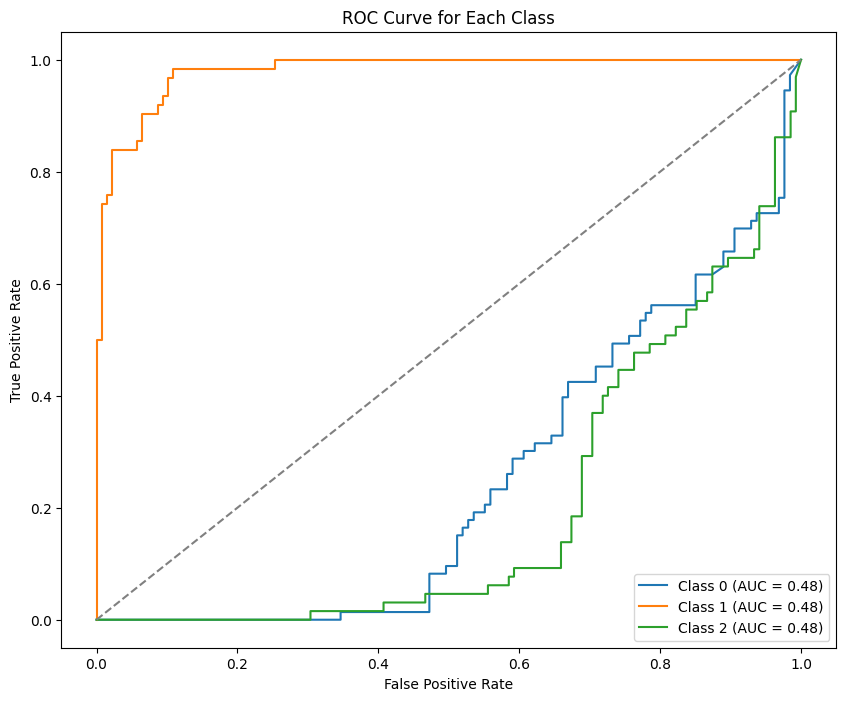

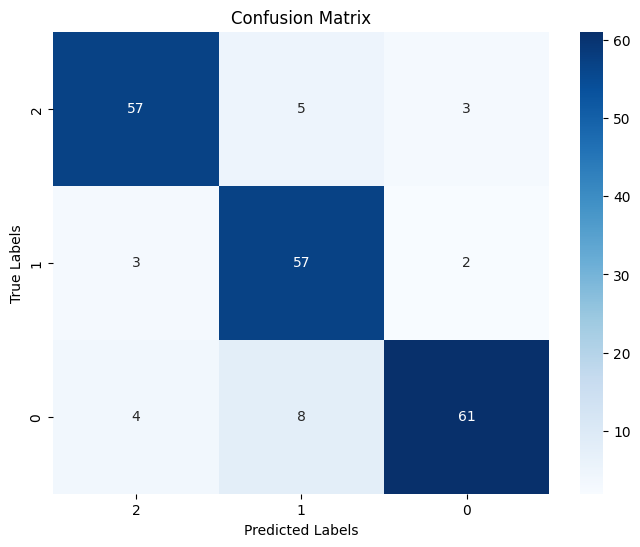

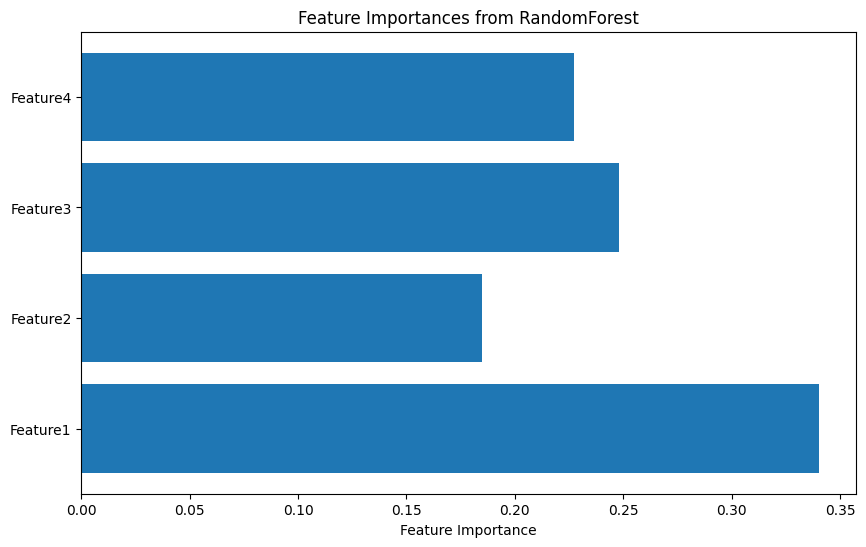

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Assuming your dataset is loaded into a pandas DataFrame 'df'
# Example: df = pd.read_csv('your_data.csv')

# Specify the target column and features
target_column_name = 'Class'  # Replace this with the actual name of your target column
X = df.drop(target_column_name, axis=1)
y = df[target_column_name]

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Train a Random Forest classifier (or any model you prefer)
clf = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}  # Example hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Step 5: Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Step 6: Compute ROC-AUC for multi-class classification
# Convert labels to binary format
y_test_bin = label_binarize(y_test, classes=df[target_column_name].unique())
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)

# Compute ROC-AUC score (Macro average for multi-class classification)
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
print(f"ROC-AUC (Macro Average): {roc_auc:.2f}")

# Step 7: Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_pred_prob[:, 0])  # Adjust for each class
plt.plot(fpr, tpr, label=f'Class 0 (AUC = {roc_auc:.2f})')  # Adjust for each class
for i in range(1, y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

# Step 8: Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df[target_column_name].unique(), yticklabels=df[target_column_name].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 9: Plot Feature Importances (for RandomForest)
feature_importances = grid_search.best_estimator_.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from RandomForest')
plt.show()


## Step 10:Hyperparameter Tuning and Cross-Validation

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.88
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        65
           1       0.82      0.94      0.87        62
           2       0.93      0.85      0.89        73

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



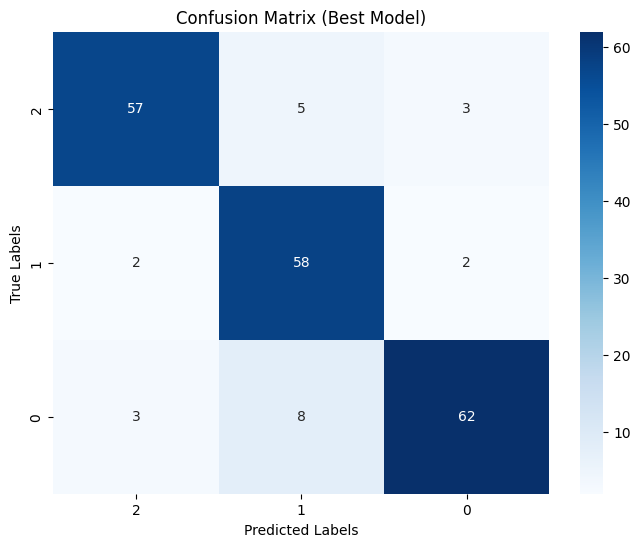

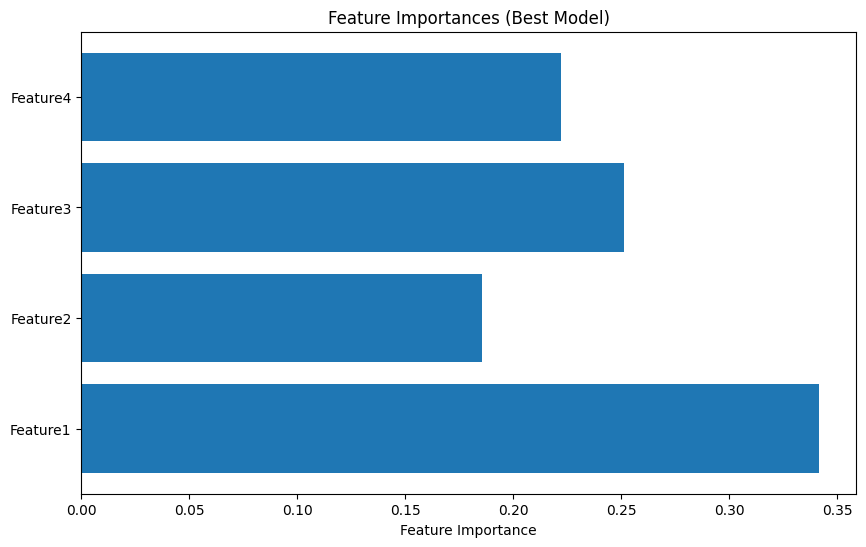

Cross-Validation Scores: [0.91875 0.86875 0.8625  0.85625 0.86875]
Mean Cross-Validation Score: 0.88


In [ ]:
from sklearn.model_selection import cross_val_score

# Step 10: Hyperparameter Tuning using GridSearchCV and Cross-Validation

# Define the parameter grid for Random Forest (you can adjust based on your model)
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [10, 20, None],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # The number of features to consider when looking for the best split
    'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV for hyperparameter tuning with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score from GridSearchCV
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred_best = best_model.predict(X_test)

# Step 11: Print classification report for the best model
class_report_best = classification_report(y_test, y_pred_best)
print("Best Model Classification Report:\n", class_report_best)

# Step 12: Plot Confusion Matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=df[target_column_name].unique(), yticklabels=df[target_column_name].unique())
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 13: Plot Feature Importances for the best model
feature_importances_best = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances_best)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Best Model)')
plt.show()

# Step 14: Perform Cross-Validation on the best model
cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean():.2f}")


Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        65
           1       0.82      0.94      0.87        62
           2       0.93      0.85      0.89        73

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



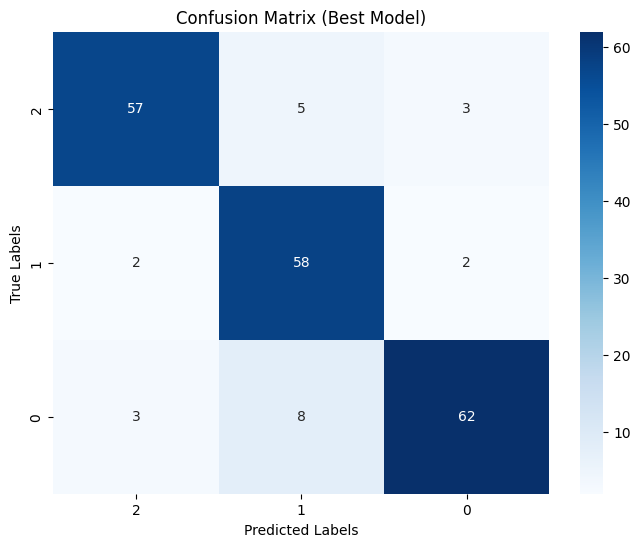

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 11: Classification Report and Confusion Matrix for the best model

# Generate predictions using the best model
y_pred_best = best_model.predict(X_test)

# 1. Classification Report
class_report_best = classification_report(y_test, y_pred_best)
print("Best Model Classification Report:\n", class_report_best)

# 2. Confusion Matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=df[target_column_name].unique(), yticklabels=df[target_column_name].unique())
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
import joblib

# Save the model
joblib.dump(best_model, 'best_model.pkl')


['best_model.pkl']